In [32]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
import galsim

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.lenses import lens_util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.helpers import gs

In [33]:
print(f'Collecting lenses...')
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir
lens_list = lens_util.get_detectable_lenses(pipeline_dir, suppress_output=False)
lens_list = [lens for lens in lens_list if lens.snr > 50]
print(f'Collected {len(lens_list)} lenses.')

100%|██████████| 18/18 [00:00<00:00, 114.69it/s]

Collected 476 lenses.


In [34]:
lens = np.random.choice(lens_list)
print(lens.snr)

51.62910560055086


In [35]:
# lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
sca = 1
sca_position = (2048, 2048)
exposure_time = 10000

rng = galsim.UniformDeviate(42)

In [36]:
image_x, image_y = lens.get_image_positions(pixel_coordinates=False)
pprint(image_x)
pprint(image_y)

array([ 0.6100276 , -0.20490904])
array([ 0.60342775, -0.14090412])


In [37]:
coords = []
for i in range(1000):
    r = 0.1 * np.sqrt(np.random.random_sample())
    theta = 2 * np.pi * np.random.random_sample()
    coords.append((theta, r))

# f, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# ax.plot([x[0] for x in coords], [x[1] for x in coords], 'o')
# ax.set_aspect('equal')
# plt.show()

In [38]:
def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

num_images = len(image_x)
rand_idx = np.random.randint(0, num_images)
halo_x = image_x[rand_idx]
halo_y = image_y[rand_idx]

# _, ax = plt.subplots()

halo_coords = []
for i in range(1000):
    theta, r = coords[i]
    x, y = polar_to_cartesian(r, theta)
    halo_coords.append((halo_x + x, halo_y + y))
#     ax.plot(halo_x + x, halo_y + y, 'o', color='blue')

# ax.plot(halo_x, halo_y, 'o', color='red')

# ax.set_aspect('equal')
# plt.show()

In [39]:
# m200 = 1e11
# concentration = 10

# Rs_angle, alpha_Rs = lens.lens_cosmo.nfw_physical2angle(M=m200, c=concentration)
# print(Rs_angle, alpha_Rs)

rand_idx = np.random.randint(0, len(halo_coords))
halo_x, halo_y = halo_coords[rand_idx]
print(halo_x, halo_y)

# subhalo_type = 'TNFW'
# kwargs_subhalo = {'alpha_Rs': alpha_Rs, 'Rs': Rs_angle, 'center_x': halo_x, 'center_y': halo_y, 'r_trunc': 5 * Rs_angle}

-0.1319069699660227 -0.18027996394103044


In [40]:
from pyHalo.single_realization import SingleHalo
from pyHalo.Halos.lens_cosmo import LensCosmo
from pyHalo.concentration_models import preset_concentration_models
from pyHalo.truncation_models import truncation_models

# set halo parameters
halo_mass = 10 ** 10
x_arcsec = halo_x
y_arcsec = halo_y
z_halo = lens.z_lens
mass_definition = 'NFW'
pyhalo_lens_cosmo = LensCosmo(lens.z_lens, lens.z_source)
astropy_class = pyhalo_lens_cosmo.cosmo

# 

# set concentration model
c_model, kwargs_concentration_model = preset_concentration_models('DIEMERJOYCE19')
kwargs_concentration_model['scatter'] = False
kwargs_concentration_model['cosmo'] = astropy_class
concentration_model = c_model(**kwargs_concentration_model)

# set truncation model
t_model, kwargs_truncation_model = truncation_models('TRUNCATION_ROCHE_GILMAN2020')
kwargs_truncation_model['lens_cosmo'] = pyhalo_lens_cosmo
pprint(kwargs_truncation_model)
truncation_model = None  # t_model()  # **kwargs_truncation_model

# build single halo class
kwargs_halo_model = {'truncation_model': truncation_model, 
                     'concentration_model': concentration_model,
                    'kwargs_density_profile': {}}
single_halo = SingleHalo(halo_mass=halo_mass, 
                         x=x_arcsec, y=y_arcsec, 
                         mdef=mass_definition, 
                         z=lens.z_lens, zlens=lens.z_lens, zsource=lens.z_source,
                        subhalo_flag=False, 
                        kwargs_halo_model=kwargs_halo_model, 
                        astropy_instance=lens.cosmo,
                        lens_cosmo=pyhalo_lens_cosmo)

{'RocheNorm': 1.4,
 'RocheNu': 0.6666666666666666,
 'lens_cosmo': <pyHalo.Halos.lens_cosmo.LensCosmo object at 0x7ff57f7a1d50>,
 'm_power': 0.3333333333333333}


In [41]:
halo = single_halo.halos[0]

print(len(single_halo.halos))

1


Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000092 by Roman in F106 band


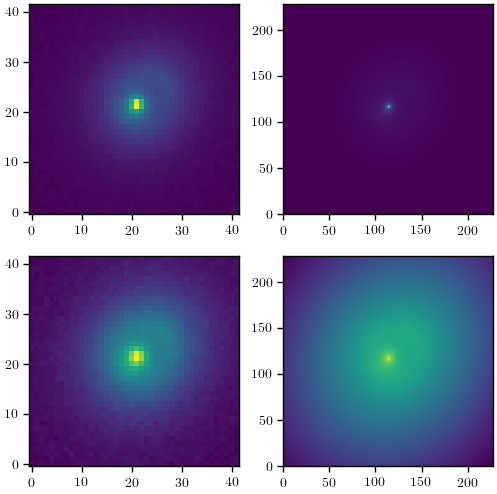

In [42]:
lens_no_subhalo = deepcopy(lens)
synth_no_subhalo = SyntheticImage(lens_no_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, sca=sca, 
                                    sca_position=sca_position)
exposure_no_subhalo = Exposure(synth_no_subhalo, exposure_time=exposure_time, rng=rng, sca=sca, 
                                    sca_position=sca_position, return_noise=True, reciprocity_failure=False, nonlinearity=False, ipc=False)

poisson_noise = exposure_no_subhalo.poisson_noise
dark_noise = exposure_no_subhalo.dark_noise
read_noise = exposure_no_subhalo.read_noise

_, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0, 0].imshow(exposure_no_subhalo.exposure)
ax[1, 0].imshow(np.log10(exposure_no_subhalo.exposure))
ax[0, 1].imshow(synth_no_subhalo.image)
ax[1, 1].imshow(np.log10(synth_no_subhalo.image))
plt.show()

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000092 by Roman in F106 band


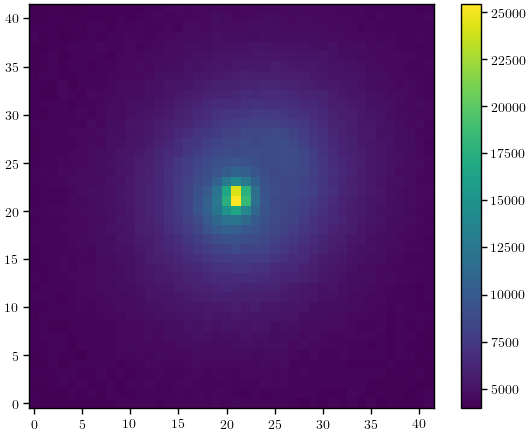

In [43]:
lens_with_subhalo = deepcopy(lens)
lens_with_subhalo.add_subhalos(single_halo)
synth = SyntheticImage(lens_with_subhalo, roman, band=band, arcsec=scene_size, oversample=oversample, sca=sca, 
                                    sca_position=sca_position)
exposure = Exposure(synth, exposure_time=exposure_time, rng=rng, sca=sca, 
                                    sca_position=sca_position, poisson_noise=poisson_noise, dark_noise=dark_noise, read_noise=read_noise, reciprocity_failure=False, nonlinearity=False, ipc=False)

plt.imshow(exposure.exposure)
plt.colorbar()
plt.show()

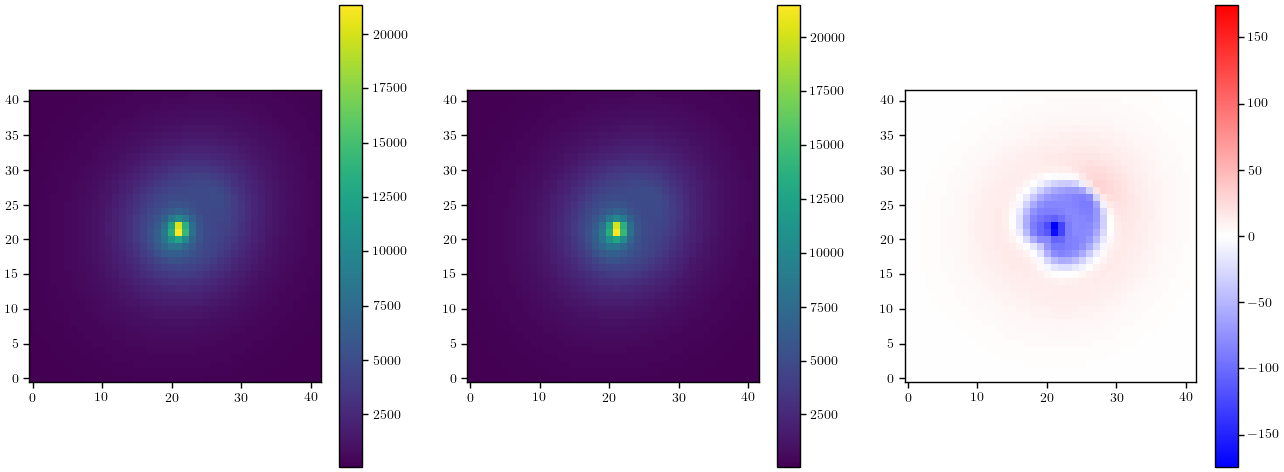

In [44]:
gs_results, _ = gs.get_images(lens_with_subhalo, [synth.image], [band], roman.zp_dict['SCA01'], input_size=51, output_size=42, grid_oversample=oversample, psf_oversample=5, detector=sca, detector_pos=sca_position, exposure_time=146, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', validate=False, sky_background=False, detector_effects=False)
gs_image = gs_results[0] * exposure_time

gs_results, _ = gs.get_images(lens_no_subhalo, [synth_no_subhalo.image], [band], roman.zp_dict['SCA01'], input_size=51, output_size=42, grid_oversample=oversample, psf_oversample=5, detector=sca, detector_pos=sca_position, exposure_time=146, psf_cache_dir='/data/bwedig/mejiro/cached_psfs', validate=False, sky_background=False, detector_effects=False)
gs_image_no_subhalos = gs_results[0] * exposure_time

residual = gs_image - gs_image_no_subhalos
vmax = plot_util.get_limit(residual)

_, ax = plt.subplots(1, 3, figsize=(16, 6))
ax0 = ax[0].imshow(gs_image)
ax1 = ax[1].imshow(gs_image_no_subhalos)
ax2 = ax[2].imshow(gs_image - gs_image_no_subhalos, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.colorbar(ax2, ax=ax[2])
plt.show()

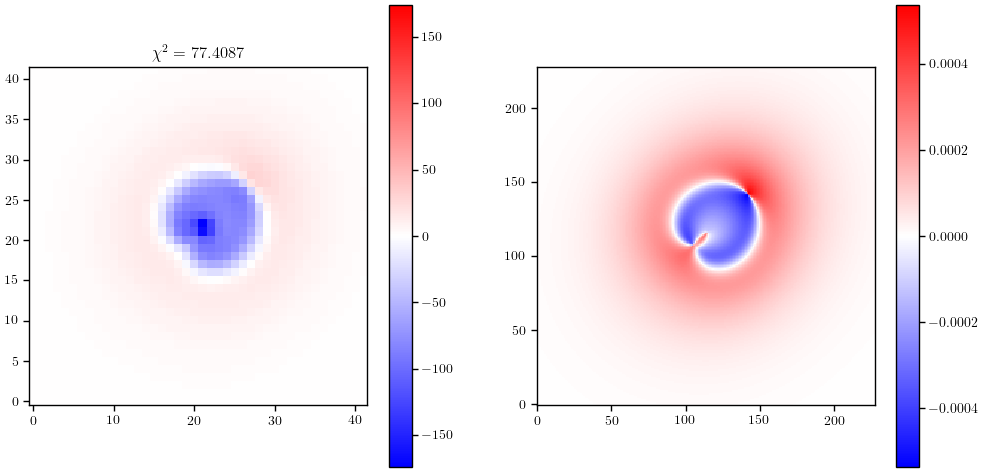

In [45]:
residual = exposure.exposure - exposure_no_subhalo.exposure
synth_residual = synth.image - synth_no_subhalo.image
                        
chi_square = stats.chi_square(exposure.exposure, exposure_no_subhalo.exposure)

vmax = plot_util.get_limit(residual)
vmax_synth = plot_util.get_limit(synth_residual)

_, ax = plt.subplots(1, 2, figsize=(12, 6))
ax0 = ax[0].imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0].set_title(r'$\chi^2=$ ' + f'{chi_square:.4f}')
ax1 = ax[1].imshow(synth_residual, cmap='bwr', vmin=-vmax_synth, vmax=vmax_synth)
plt.colorbar(ax0, ax=ax[0])
plt.colorbar(ax1, ax=ax[1])
plt.show()